<a href="https://colab.research.google.com/github/AnanyaUp/Quantum-Machine-Learning/blob/main/QML_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# QUANTUM BAYESIAN NETWORK – TITANIC SURVIVAL - MIMICED AS PER BOOK

!pip install -q qiskit qiskit-aer pandas numpy scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
from math import asin, sqrt, log
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from IPython.display import display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.4 MB/s eta 0:00:00


In [ ]:
def prob_to_angle(p):
    return 2 * asin(sqrt(max(0.0, min(1.0, p))))

def as_pqc(n_qubits, builder, hist=False, measure=False, shots=8192):
    qr = QuantumRegister(n_qubits, 'q')
    cr = ClassicalRegister(1, 'c') if measure else None
    qc = QuantumCircuit(qr, cr) if measure else QuantumCircuit(qr)
    builder(qc)

    sim = AerSimulator()

    if measure:
        qc.measure(qr[QPOS_SURV], 0)
        result = sim.run(qc, shots=shots).result()
        counts = result.get_counts()
    else:
        qc.save_statevector()
        result = sim.run(qc).result()
        sv = np.asarray(result.get_statevector())  # ← NO WARNING!
        counts = {}
        for i, amp in enumerate(sv):
            p = np.abs(amp)**2
            if p > 1e-12:
                state = format(i, f'0{n_qubits}b')[::-1]
                counts[state] = float(p)

    if hist:
        display(plot_histogram(counts, figsize=(12,4)))
    return counts



In [ ]:
# Toy Example – Listings 10.1–10.13
data = [(1,1), (1,1), (0,0), (0,0), (0,0), (0,None), (0,1), (1,0)]

def log_likelihood(data, p11, p01, p10, p00):
    total = 0.0
    for a, b in data:
        if b is None:
            total += log(p10 + p00 + 1e-20)
        elif a == 1 and b == 1: total += log(p11 + 1e-20)
        elif a == 1 and b == 0: total += log(p01 + 1e-20)
        elif a == 0 and b == 1: total += log(p10 + 1e-20)
        else:                    total += log(p00 + 1e-20)
    return total

def qbn(toy_data, hist=True):
    def circuit(qc):
        n = len(toy_data)
        n_a = sum(1 for a,_ in toy_data if a == 1)
        qc.ry(prob_to_angle(n_a/n), 0)
        qc.x(0)
        na_b = sum(1 for a,b in toy_data if a == 0 and b == 1)
        na = sum(1 for a,_ in toy_data if a == 0) or 1
        qc.cry(prob_to_angle(na_b/na), 0, 1)
        qc.x(0)
        a_b = sum(1 for a,b in toy_data if a == 1 and b == 1)
        a = n_a or 1
        qc.cry(prob_to_angle(a_b/a), 0, 1)
    return as_pqc(2, circuit, hist=hist)

def eval_toy(prep):
    res = qbn(prep(data), hist=False)
    ll = log_likelihood(data, res.get('11',0), res.get('01',0), res.get('10',0), res.get('00',0))
    cond = res.get('10',0) / (res.get('10',0) + res.get('00',0) + 1e-20)
    return round(ll, 3), round(cond, 4)


=== Listing 10.6 – Toy QBN: Ignoring Missing Data ===


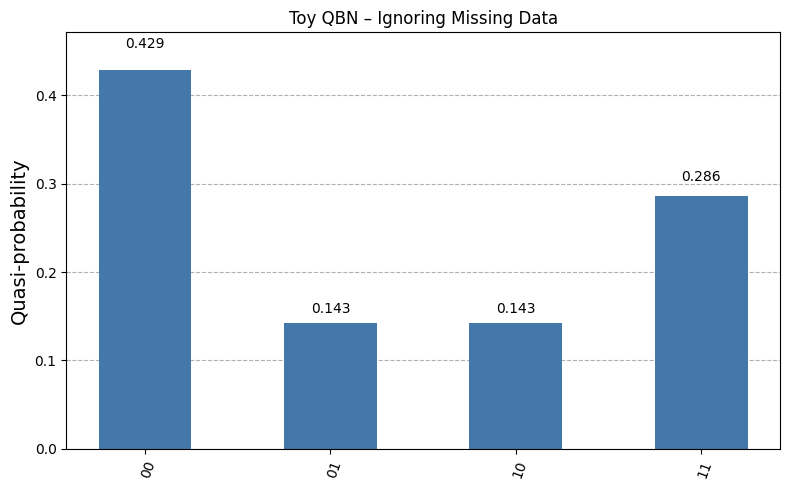


=== Toy Example Results ===
(-9.499, 0.25)
(-9.481, 0.2)
(-9.481, 0.2)
(-9.481, 0.2)
(-9.481, 0.2)
(-9.481, 0.2)


In [ ]:
print("=== Listing 10.6 – Toy QBN: Ignoring Missing Data ===")
counts_toy = qbn([x for x in data if x[1] is not None], hist=False)
display(plot_histogram(counts_toy, title="Toy QBN – Ignoring Missing Data", color='#4477AA', figsize=(8,5)))

print("\n=== Toy Example Results ===")
for prep in [
    lambda d: [x for x in d if x[1] is not None],
    lambda d: [(a,0) if b is None else (a,b) for a,b in d],
    lambda d: [(a,0.5) if b is None else (a,b) for a,b in d],
    lambda d: [(a,0.3) if b is None else (a,b) for a,b in d],
    lambda d: [(a,0.26) if b is None else (a,b) for a,b in d],
    lambda d: [(a,0.252) if b is None else (a,b) for a,b in d],
]:
    print(eval_toy(prep))

strategies = ["Ignore", "B=0", "B=0.5", "B=0.3", "B=0.26", "B=0.252 (opt)"]
conds = [eval_toy(prep)[1] for prep in [
    lambda d: [x for x in d if x[1] is not None],
    lambda d: [(a,0) if b is None else (a,b) for a,b in d],
    lambda d: [(a,0.5) if b is None else (a,b) for a,b in d],
    lambda d: [(a,0.3) if b is None else (a,b) for a,b in d],
    lambda d: [(a,0.26) if b is None else (a,b) for a,b in d],
    lambda d: [(a,0.252) if b is None else (a,b) for a,b in d],
]]


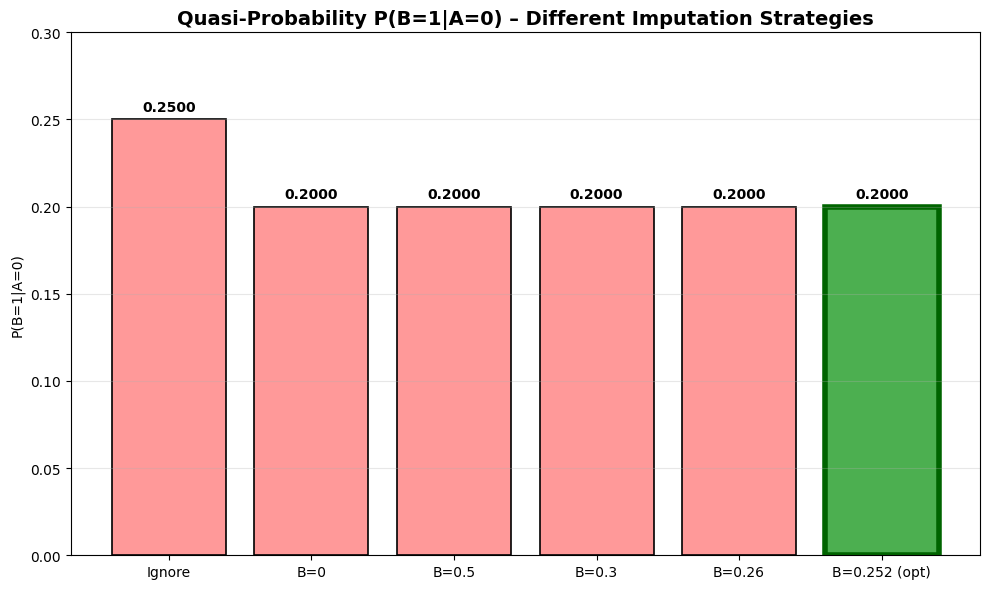

In [ ]:
plt.figure(figsize=(10,6))
bars = plt.bar(strategies, conds, color=['#FF9999']*5 + ['#4CAF50'], edgecolor='black', linewidth=1.2)
plt.title('Quasi-Probability P(B=1|A=0) – Different Imputation Strategies', fontsize=14, fontweight='bold')
plt.ylabel('P(B=1|A=0)'); plt.ylim(0, 0.3)
for i, v in enumerate(conds):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')
bars[-1].set_edgecolor('darkgreen'); bars[-1].set_linewidth(4)
plt.grid(True, axis='y', alpha=0.3); plt.tight_layout(); plt.show()

# Titanic Setup
!wget -q https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv -O train.csv
train = pd.read_csv('train.csv')
train['Age'] = train['Age'].fillna(train['Age'].median())

max_child_age = 8
QPOS_ISCHILD, QPOS_SEX, QPOS_NORM = 0, 1, 2
QPOS_FIRST, QPOS_SECOND, QPOS_THIRD, QPOS_SURV = 3, 4, 5, 6
QUBITS = 7

p_child = (train.Age <= max_child_age).mean()
p_female = (train.Sex == 'female').mean()
p_first = (train.Pclass == 1).mean()
p_second = (train.Pclass == 2).mean()



=== Listing 10.20 – Full 7-Qubit Distribution ===


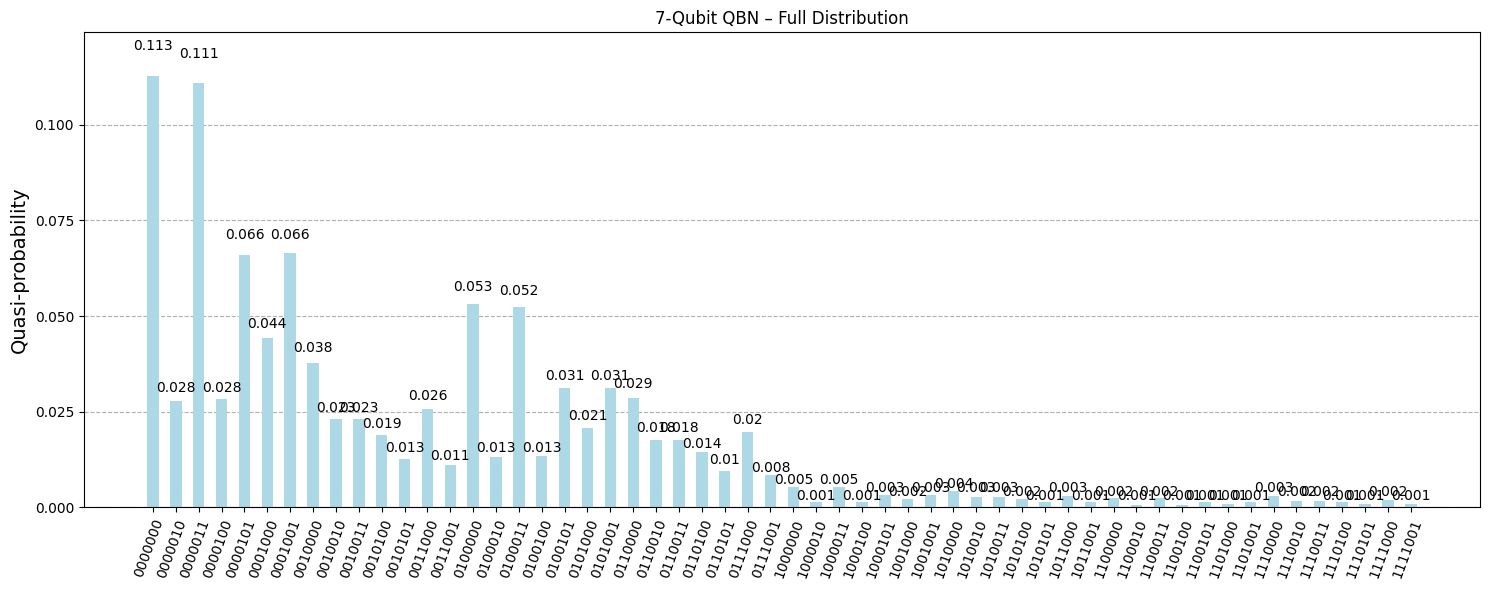

In [ ]:
def apply_ischild_sex(qc):
    qc.ry(prob_to_angle(p_child), QPOS_ISCHILD)
    qc.ry(prob_to_angle(p_female), QPOS_SEX)

def ccry(qc, theta, c1, c2, t):
    qc.cry(theta/2, c2, t); qc.cx(c1, c2); qc.cry(-theta/2, c2, t); qc.cx(c1, c2); qc.cry(theta/2, c1, t)

def apply_class(qc):
    qc.ry(prob_to_angle(p_first), QPOS_FIRST)
    qc.x(QPOS_FIRST); qc.cry(prob_to_angle(p_second/(1-p_first)), QPOS_FIRST, QPOS_SECOND); qc.x(QPOS_FIRST)
    qc.x(QPOS_FIRST); qc.x(QPOS_SECOND)
    ccry(qc, prob_to_angle(1-p_first-p_second), QPOS_FIRST, QPOS_SECOND, QPOS_THIRD)
    qc.x(QPOS_FIRST); qc.x(QPOS_SECOND)

def apply_norm(qc, params):
    am = params.get('p_norm_am',0.5); af = params.get('p_norm_af',0.5)
    cm = params.get('p_norm_cm',0.5); cf = params.get('p_norm_cf',0.5)
    qc.x(QPOS_ISCHILD); qc.x(QPOS_SEX); ccry(qc, prob_to_angle(am), QPOS_ISCHILD, QPOS_SEX, QPOS_NORM); qc.x(QPOS_ISCHILD); qc.x(QPOS_SEX)
    qc.x(QPOS_ISCHILD);                     ccry(qc, prob_to_angle(af), QPOS_ISCHILD, QPOS_SEX, QPOS_NORM); qc.x(QPOS_ISCHILD)
    qc.x(QPOS_SEX);                         ccry(qc, prob_to_angle(cm), QPOS_ISCHILD, QPOS_SEX, QPOS_NORM); qc.x(QPOS_SEX)
    ccry(qc, prob_to_angle(cf), QPOS_ISCHILD, QPOS_SEX, QPOS_NORM)

def apply_survival(qc, params):
    qc.x(QPOS_NORM)
    for c,k in zip([QPOS_FIRST,QPOS_SECOND,QPOS_THIRD], ['p_surv_u1','p_surv_u2','p_surv_u3']):
        ccry(qc, prob_to_angle(params[k]), QPOS_NORM, c, QPOS_SURV)
    qc.x(QPOS_NORM)
    for c,k in zip([QPOS_FIRST,QPOS_SECOND,QPOS_THIRD], ['p_surv_f1','p_surv_f2','p_surv_f3']):
        ccry(qc, prob_to_angle(params[k]), QPOS_NORM, c, QPOS_SURV)

def qbn_titanic(norm_params, surv_params, hist=False, measure=False, shots=8192):
    def circuit(qc):
        apply_ischild_sex(qc)
        apply_norm(qc, norm_params)
        apply_class(qc)
        apply_survival(qc, surv_params)
    return as_pqc(QUBITS, circuit, hist=hist, measure=measure, shots=shots)

print("\n=== Listing 10.20 – Full 7-Qubit Distribution ===")
counts_full = qbn_titanic(
    norm_params={'p_norm_am':0.25,'p_norm_af':0.35,'p_norm_cm':0.45,'p_norm_cf':0.55},
    surv_params={'p_surv_f1':0.3,'p_surv_f2':0.4,'p_surv_f3':0.5,'p_surv_u1':0.6,'p_surv_u2':0.7,'p_surv_u3':0.8},
    hist=False
)
display(plot_histogram(counts_full, title="7-Qubit QBN – Full Distribution", color='lightblue', figsize=(15,6)))



=== EM TRAINING – 25 ITERATIONS ===
Iteration  1 → Log-Likelihood = -1966.171
Iteration  2 → Log-Likelihood = -1960.596
Iteration  3 → Log-Likelihood = -1960.772
Iteration  4 → Log-Likelihood = -1960.775
Iteration  5 → Log-Likelihood = -1960.775
Iteration  6 → Log-Likelihood = -1960.775
Iteration  7 → Log-Likelihood = -1960.775
Iteration  8 → Log-Likelihood = -1960.775
Iteration  9 → Log-Likelihood = -1960.775
Iteration 10 → Log-Likelihood = -1960.775
Iteration 11 → Log-Likelihood = -1960.775
Iteration 12 → Log-Likelihood = -1960.775
Iteration 13 → Log-Likelihood = -1960.775
Iteration 14 → Log-Likelihood = -1960.775
Iteration 15 → Log-Likelihood = -1960.775
Iteration 16 → Log-Likelihood = -1960.775
Iteration 17 → Log-Likelihood = -1960.775
Iteration 18 → Log-Likelihood = -1960.775
Iteration 19 → Log-Likelihood = -1960.775
Iteration 20 → Log-Likelihood = -1960.775
Iteration 21 → Log-Likelihood = -1960.775
Iteration 22 → Log-Likelihood = -1960.775
Iteration 23 → Log-Likelihood = -1960.7

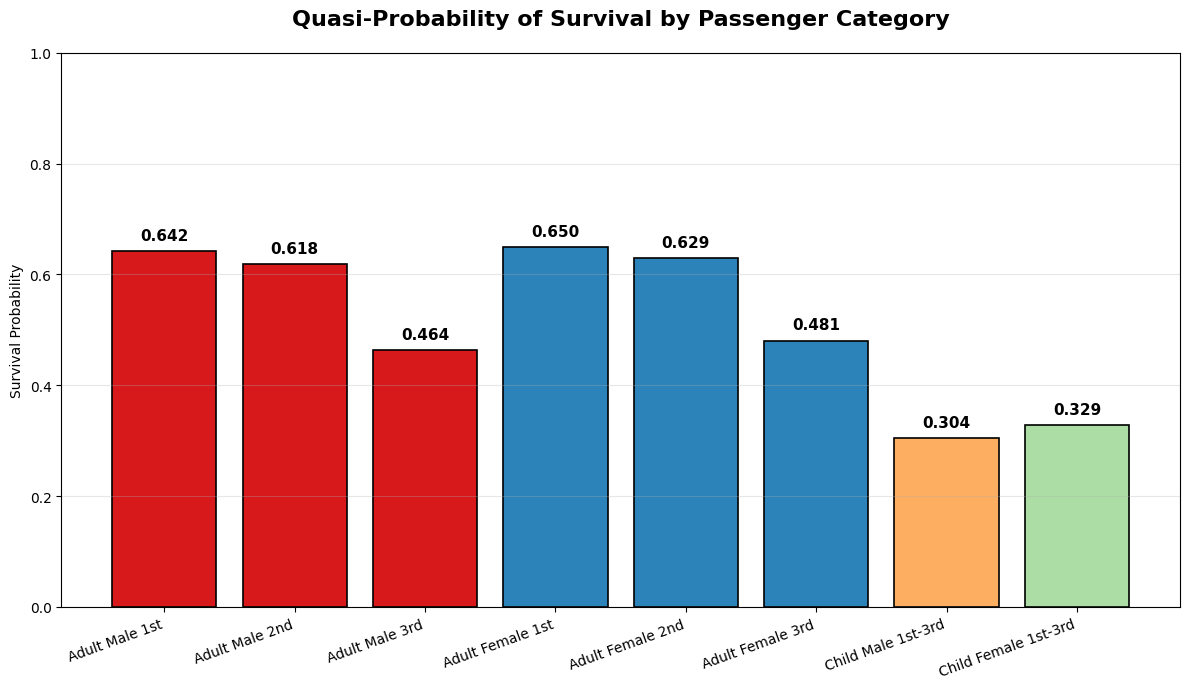


     QUANTUM BAYESIAN NETWORK – FINAL RESULTS
Precision       : 0.5379
Recall          : 0.6842
Specificity     : 0.6339
NPV             : 0.7632
Information Level: 0.6548
Accuracy        : 0.6532


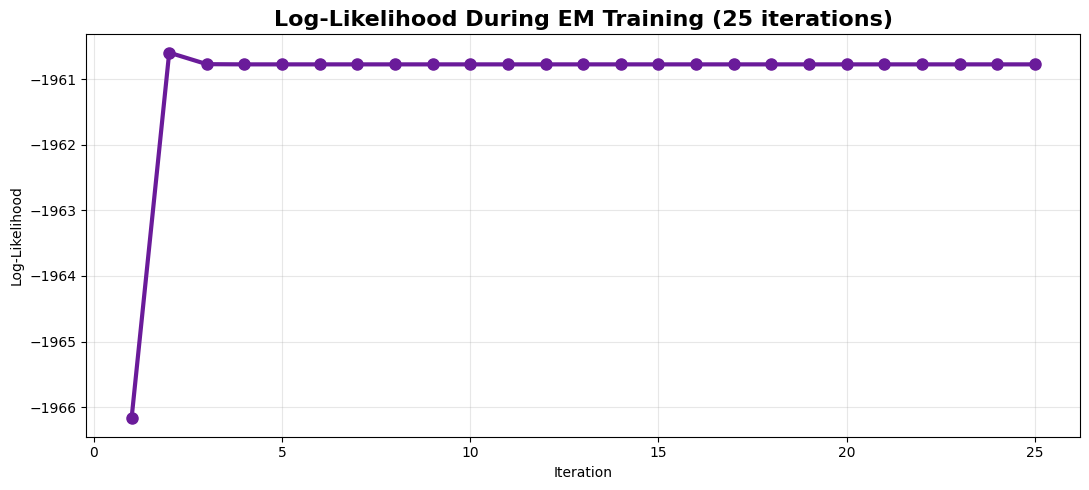

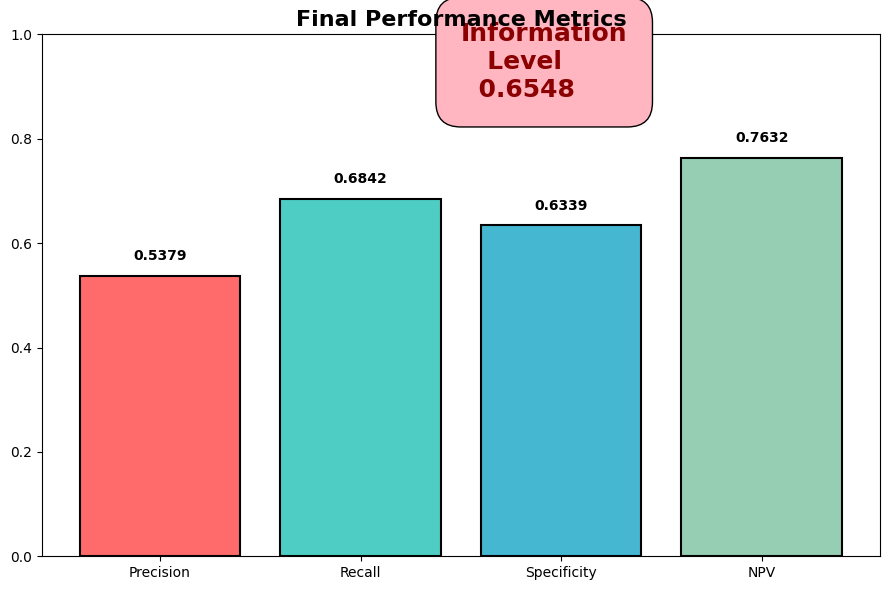

In [ ]:
# EM TRAINING
def prepare_data(df, params):
    df = df.copy()
    df['IsChild'] = (df.Age <= max_child_age).astype(int)
    def get_norm(row):
        key = f'p_norm_{"c" if row.IsChild else "a"}{row.Sex[0]}{"s" if row.Survived else "d"}'
        return params[key]
    df['Norm'] = df.apply(get_norm, axis=1)
    return df

def calculate_norm_params(df):
    groups = {
        'am': (df['IsChild'] == 0) & (df['Sex'] == 'male'),
        'af': (df['IsChild'] == 0) & (df['Sex'] == 'female'),
        'cm': (df['IsChild'] == 1) & (df['Sex'] == 'male'),
        'cf': (df['IsChild'] == 1) & (df['Sex'] == 'female'),
    }
    result = {}
    for name, mask in groups.items():
        group = df[mask]
        if len(group) > 0:
            result[f'p_norm_{name}'] = group['Norm'].sum() / len(group)
        else:
            result[f'p_norm_{name}'] = 0.5
    return result

def calculate_surv_params(df):
    def prob(favored, cls):
        sub = df[df.Pclass == cls]
        if len(sub) == 0: return 0.5
        w = sub.Norm if favored else (1 - sub.Norm)
        return (sub.Survived * w).sum() / w.sum() if w.sum() > 0 else 0.5
    return {f'p_surv_{f}{c}': prob(f=='f',c) for f in 'fu' for c in [1,2,3]}

def to_params(results):
    def calc(ischild, female, survived):
        filtered = {k:v for k,v in results.items()
                    if k[6-QPOS_ISCHILD]==str(ischild) and k[6-QPOS_SEX]==str(female) and k[6-QPOS_SURV]==str(survived)}
        total = sum(filtered.values())
        if total == 0: return 0.5
        return sum(v for k,v in filtered.items() if k[6-QPOS_NORM]=='1') / total
    return {
        'p_norm_cms': calc(1,0,1), 'p_norm_cmd': calc(1,0,0),
        'p_norm_cfs': calc(1,1,1), 'p_norm_cfd': calc(1,1,0),
        'p_norm_ams': calc(0,0,1), 'p_norm_amd': calc(0,0,0),
        'p_norm_afs': calc(0,1,1), 'p_norm_afd': calc(0,1,0),
    }

def titanic_log_likelihood(df, results):
    total = 0.0
    for _, row in df.iterrows():
        i, f, s = row.IsChild, int(row.Sex=='female'), row.Survived
        p = sum(v for k,v in results.items()
                if k[6-QPOS_ISCHILD]==str(i) and k[6-QPOS_SEX]==str(f) and k[6-QPOS_SURV]==str(s))
        total += log(p + 1e-20)
    return round(total, 3)

print("\n=== EM TRAINING – 25 ITERATIONS ===")
ll_history = []
latent_params = {
    'p_norm_cms':0.45,'p_norm_cmd':0.46,'p_norm_cfs':0.47,'p_norm_cfd':0.48,
    'p_norm_ams':0.49,'p_norm_amd':0.51,'p_norm_afs':0.52,'p_norm_afd':0.53,
}

for it in range(1, 26):
    df = prepare_data(train, latent_params)
    norm_p = calculate_norm_params(df)
    surv_p = calculate_surv_params(df)
    results = qbn_titanic(norm_p, surv_p, hist=False)
    ll = titanic_log_likelihood(df, results)
    ll_history.append(ll)
    print(f"Iteration {it:2d} → Log-Likelihood = {ll}")
    latent_params = to_params(results)

trained_params = latent_params


print("\n=== Quasi-Probability of Survival by Passenger Category ===")
final_df = prepare_data(train, trained_params)
final_norm_p = calculate_norm_params(final_df)
final_surv_p = calculate_surv_params(final_df)

categories = [
    ("Adult Male 1st",     0, 0, 1),
    ("Adult Male 2nd",     0, 0, 2),
    ("Adult Male 3rd",     0, 0, 3),
    ("Adult Female 1st",   0, 1, 1),
    ("Adult Female 2nd",   0, 1, 2),
    ("Adult Female 3rd",   0, 1, 3),
    ("Child Male 1st-3rd", 1, 0, None),
    ("Child Female 1st-3rd",1, 1, None),
]

survival_probs = []

for label, is_child, is_female, pclass in categories:
    def circuit(qc):
        apply_ischild_sex(qc)
        apply_class(qc)
        if is_child: qc.x(QPOS_ISCHILD)
        if is_female: qc.x(QPOS_SEX)
        if pclass is not None:
            if pclass == 1: qc.x(QPOS_FIRST)
            elif pclass == 2: qc.x(QPOS_SECOND)
            else: qc.x(QPOS_THIRD)
        apply_norm(qc, final_norm_p)
        apply_survival(qc, final_surv_p)
        qc.measure(QPOS_SURV, 0)
    counts = as_pqc(QUBITS, circuit, measure=True, shots=8192)
    p_surv = counts.get('1', 0) / 8192
    survival_probs.append(p_surv)

plt.figure(figsize=(12, 7))
colors = ['#d7191c']*3 + ['#2b83ba']*3 + ['#fdae61', '#abdda4']
bars = plt.bar(range(len(categories)), survival_probs, color=colors, edgecolor='black', linewidth=1.2)
plt.title('Quasi-Probability of Survival by Passenger Category', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Survival Probability')
plt.ylim(0, 1)
plt.xticks(range(len(categories)), [cat for cat, _, _, _ in categories], rotation=20, ha='right', fontsize=10)
for i, (bar, prob) in enumerate(zip(bars, survival_probs)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{prob:.3f}', ha='center', fontweight='bold', fontsize=11)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Final Classifier & Results
def pre_process(row):
    return (row.Age <= max_child_age, row.Sex == 'female', row.Pclass)

def apply_known(qc, is_child, is_female, pclass):
    if is_child: qc.x(QPOS_ISCHILD)
    if is_female: qc.x(QPOS_SEX)
    if pclass == 1: qc.x(QPOS_FIRST)
    elif pclass == 2: qc.x(QPOS_SECOND)
    else: qc.x(QPOS_THIRD)

def get_trained_classifier():
    df = prepare_data(train, trained_params)
    norm_p = calculate_norm_params(df)
    surv_p = calculate_surv_params(df)
    def classifier(passenger):
        is_child, is_female, pclass = passenger
        def circuit(qc):
            apply_ischild_sex(qc); apply_class(qc); apply_known(qc, is_child, is_female, pclass)
            apply_norm(qc, norm_p); apply_survival(qc, surv_p); qc.measure(QPOS_SURV, 0)
        counts = as_pqc(QUBITS, circuit, measure=True, shots=1024)
        return 1 if counts.get('1',0) > counts.get('0',0) else 0
    return classifier

clf = get_trained_classifier()
preds = [clf(pre_process(row)) for _, row in train.iterrows()]

cm = confusion_matrix(train.Survived, preds)
prec = precision_score(train.Survived, preds)
rec  = recall_score(train.Survived, preds)
spec = cm[0,0] / cm[0].sum()
npv  = cm[0,0] / cm[:,0].sum()
level = 0.25 * (prec + rec + spec + npv)


print("\n" + "="*70)
print("     QUANTUM BAYESIAN NETWORK – FINAL RESULTS")
print("="*70)
print(f"Precision       : {prec:.4f}")
print(f"Recall          : {rec:.4f}")
print(f"Specificity     : {spec:.4f}")
print(f"NPV             : {npv:.4f}")
print(f"Information Level: {level:.4f}")
print(f"Accuracy        : {np.mean(train.Survived == preds):.4f}")
print("="*70)

plt.figure(figsize=(11,5))
plt.plot(range(1,26), ll_history, 'o-', color='#6A1B9A', linewidth=3, markersize=8)
plt.title('Log-Likelihood During EM Training (25 iterations)', fontsize=16, fontweight='bold')
plt.xlabel('Iteration'); plt.ylabel('Log-Likelihood'); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

metrics = ['Precision', 'Recall', 'Specificity', 'NPV']
values = [prec, rec, spec, npv]
plt.figure(figsize=(9,6))
bars = plt.bar(metrics, values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'], edgecolor='black', linewidth=1.5)
plt.ylim(0,1); plt.title('Final Performance Metrics', fontsize=16, fontweight='bold')
for bar, v in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03, f'{v:.4f}', ha='center', fontweight='bold')
plt.text(1.5, 0.88, f'Information\n   Level\n  {level:.4f}', fontsize=18, fontweight='bold',
         color='darkred', bbox=dict(boxstyle="round,pad=1", facecolor="#FFB6C1"))
plt.tight_layout(); plt.show()
